# Train target model

We train a model in two steps, first by regressing out sequence information unique to the endogenous
context and then train a model on target features.


In [21]:
import plotnine as gg
import pandas as pd
import joblib
from joblib import Parallel, delayed
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.base import clone
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import shap
import optuna
import sglearn
import numpy as np
from scipy import stats
from datetime import datetime
from Bio.SeqUtils import ProtParamData

from datasets import dataset_list, get_sg_groups_df
import target_featurization as ft

In [2]:
def lgbm_training_iteration(fold_df, train_index,
                            base_nt_model,
                            target_features,
                            aa_seq_df, protein_domain_df,
                            conservation_df,
                            test_index, base_target_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param target_features: list, features to use
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :param test_index: list-like
    :param base_target_model: LGBMRegressor
    :return: r^2
    """
    # Step 1 - train seq model
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    X_train_val_seq = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
    y_train_val_seq = train_df['Residual Activity']
    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(X_train_val_seq, y_train_val_seq,
                                                                      test_size=0.1, random_state=7)
    nt_model = clone(base_nt_model)
    nt_model.fit(X_train_seq, y_train_seq,
                 early_stopping_rounds=20,
                 eval_set=[(X_val_seq, y_val_seq)],
                 verbose=False)
    # Step 2 - train the target model using the seq model's residuals
    (train_target_feature_df,
     train_target_feature_cols) = ft.build_target_feature_df(train_df,
                                                             features=target_features,
                                                             aa_seq_df=aa_seq_df,
                                                             protein_domain_df=protein_domain_df,
                                                             conservation_df=conservation_df)
    X_train_val_target = train_target_feature_df[train_target_feature_cols]  # train and validation data
    y_train_val_target = train_df['Residual Activity'] - nt_model.predict(X_train_val_seq)  # take residual of nt model
    X_train_target, X_val_target, y_train_target, y_val_target = train_test_split(X_train_val_target,
                                                                                  y_train_val_target,
                                                                                 test_size=0.1, random_state=7)
    target_model = clone(base_target_model)
    target_model.fit(X_train_target, y_train_target,
                     regressor__early_stopping_rounds=20,
                     regressor__eval_set=[(X_val_target, y_val_target)],
                     regressor__verbose=False)
    # test the model
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    X_test_seq = sglearn.featurize_guides(test_df['sgRNA Context Sequence'])
    (test_target_feature_df,
     test_target_feature_cols) = ft.build_target_feature_df(test_df,
                                                            features=target_features,
                                                            aa_seq_df=aa_seq_df,
                                                            protein_domain_df=protein_domain_df,
                                                            conservation_df=conservation_df)
    X_test_target = test_target_feature_df[test_target_feature_cols]
    test_predictions = test_df.copy()
    test_predictions['prediction'] = nt_model.predict(X_test_seq) + target_model.predict(X_test_target)
    r2 = r2_score(test_predictions['Residual Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(fold_df, features, aa_seq_df, protein_domain_df, conservation_df):
    """Get objective function for training a lgbm model

    :param fold_df: DataFrame
    :param features: list
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for lgbm

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        nt_num_leaves = trial.suggest_int('nt_num_leaves', 8, 256)
        nt_min_child_samples = trial.suggest_int('nt_min_child_samples', 8, 256)
        nt_model = LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                                 num_leaves=nt_num_leaves,
                                 min_child_sample=nt_min_child_samples)
        target_num_leaves = trial.suggest_int('target_num_leaves', 8, 256)
        target_min_child_samples = trial.suggest_int('target_min_child_samples', 8, 256)
        target_model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                 ('regressor',
                                  LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                                                num_leaves=target_num_leaves,
                                                min_child_samples=target_min_child_samples))])
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (fold_df, train_index,
                                          nt_model,
                                          features,
                                          aa_seq_df, protein_domain_df,
                                          conservation_df,
                                          test_index, target_model) for
                                         train_index, test_index in
                                         sgkf.split(fold_df, fold_df.dataset, fold_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective


def lolliplop_plot(data, cat, val):
    g = (gg.ggplot(data) +
         gg.aes(y=val, ymin=0, ymax=val, x=cat, xend=cat) +
         gg.geom_point(size=4, shape='.') +
         gg.geom_linerange() +
         gg.coord_flip() +
         gg.theme_classic())
    return g

In [3]:
## Reading Data

In [4]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')
seq_model = joblib.load('../models/RuleSet3.pkl')
codon_map_df = pd.read_csv('../data/external/codon_map.csv')

### Rename Database Columns

In [5]:
aa_seqs = aa_seqs.rename({'query': 'Transcript Base'}, axis=1)
protein_domains = protein_domains.rename({'Parent': 'Transcript Base'}, axis=1)

## Loading Datasets

In [6]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        if ds.endogenous:
            train_data_list.append(ds)


sg_groups_df = get_sg_groups_df(train_data_list)
sg_groups_df = ft.add_target_columns(sg_groups_df)

Context sequences with multiple targets: 0


## Read Conservation Data

In [7]:
transcript_bases = list(sg_groups_df['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))
conservation_df['ranked_conservation'] = (conservation_df.groupby('Transcript Base')
                                          ['conservation']
                                          .rank(pct=True))

## Calculate Residuals

In [8]:
sg_df_residuals = sg_groups_df.copy()
sg_df_residuals['sgRNA Activity'] = (sg_df_residuals.groupby('dataset')
                                     ['sgRNA Activity']
                                     .rank(pct=True))
seq_X = sglearn.featurize_guides(sg_df_residuals['sgRNA Context Sequence'])
sg_df_residuals['Rule Set 3'] = seq_model.predict(seq_X)
(sg_df_residuals.groupby('dataset')
 .apply(lambda df: stats.pearsonr(df['Rule Set 3'], df['sgRNA Activity'])))

dataset
Doench2014_human     (0.7747588150394162, 6.327280047472541e-200)
Doench2014_mouse    (0.7221909327038771, 4.8841724249361805e-189)
Doench2016                        (0.6639725734142461, 3.06e-322)
Wang2014              (0.740204397054155, 4.967999241925921e-178)
dtype: object

In [9]:
sg_df_residuals['Residual Activity'] = sg_df_residuals['sgRNA Activity'] - sg_df_residuals['Rule Set 3']

In [10]:
## Training Model

In [11]:
features = ['position', 'aa', 'domain', 'conservation'] # no nt
aa_features = ['Pos. Ind. 1mer', 'Hydrophobicity', 'Aromaticity',
               'Isoelectric Point', 'Secondary Structure']
aa_width = 8
cons_small_width=2
cons_large_width=32
n_trials = 50
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
objective = get_lgbm_objective(sg_df_residuals, features=features,
                               aa_seq_df=aa_seqs, protein_domain_df=protein_domains,
                               conservation_df=conservation_df)
start_time = datetime.now()
study.optimize(objective, n_trials=n_trials)
end_time = datetime.now()
difference = end_time - start_time
print("Number of finished trials: {}".format(len(study.trials)))
print("Training Time: " + str(difference))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Using optimal parameters, retrain model with full dataset

train_df = sg_df_residuals.copy()
X_train_val_seq = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
y_train_val_seq = train_df['Residual Activity']
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(X_train_val_seq, y_train_val_seq,
                                                                  test_size=0.1, random_state=7)
nt_model = LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                         num_leaves=trial.params['nt_num_leaves'],
                         min_child_samples=trial.params['nt_min_child_samples'])
nt_model.fit(X_train_seq, y_train_seq,
             early_stopping_rounds=20,
             eval_set=[(X_val_seq, y_val_seq)],
             verbose=False)
# Step 2 - train the target model using the seq model's residuals
(train_target_feature_df,
 train_target_feature_cols) = ft.build_target_feature_df(train_df,
                                                         features=features,
                                                         aa_seq_df=aa_seqs,
                                                         protein_domain_df=protein_domains,
                                                         conservation_df=conservation_df)
X_train_val_target = train_target_feature_df[train_target_feature_cols]  # train and validation data
y_train_val_target = train_df['Residual Activity'] - nt_model.predict(X_train_val_seq)  # take residual of nt model
X_train_target, X_val_target, y_train_target, y_val_target = train_test_split(X_train_val_target,
                                                                              y_train_val_target,
                                                                              test_size=0.1, random_state=7)
target_model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('regressor', LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01,
                                                     n_estimators=5000,
                                                     num_leaves=trial.params['target_num_leaves'],
                                                     min_child_samples=trial.params['target_min_child_samples']))])
target_model.fit(X_train_target, y_train_target,
                 regressor__early_stopping_rounds=20,
                 regressor__eval_set=[(X_val_target, y_val_target)],
                 regressor__verbose=False)

[I 2021-05-16 14:30:22,271] A new study created in memory with name: no-name-cd92bc58-bcb8-481c-9f68-feadfd4eeb65
[I 2021-05-16 14:30:33,684] Trial 0 finished with value: 0.0694806916231729 and parameters: {'nt_num_leaves': 27, 'nt_min_child_samples': 202, 'target_num_leaves': 117, 'target_min_child_samples': 188}. Best is trial 0 with value: 0.0694806916231729.
[I 2021-05-16 14:30:42,932] Trial 1 finished with value: 0.04091188838860684 and parameters: {'nt_num_leaves': 251, 'nt_min_child_samples': 142, 'target_num_leaves': 132, 'target_min_child_samples': 25}. Best is trial 0 with value: 0.0694806916231729.
[I 2021-05-16 14:30:52,306] Trial 2 finished with value: 0.06066043468088922 and parameters: {'nt_num_leaves': 74, 'nt_min_child_samples': 132, 'target_num_leaves': 177, 'target_min_child_samples': 208}. Best is trial 0 with value: 0.0694806916231729.
[I 2021-05-16 14:31:00,131] Trial 3 finished with value: 0.0665615080547975 and parameters: {'nt_num_leaves': 102, 'nt_min_child_sa

Number of finished trials: 50
Training Time: 0:06:51.133106
Best trial:
  Value: 0.08107335672560845
  Params: 
    nt_num_leaves: 10
    nt_min_child_samples: 250
    target_num_leaves: 204
    target_min_child_samples: 176


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 LGBMRegressor(learning_rate=0.01, min_child_samples=176,
                               n_estimators=5000, n_jobs=8, num_leaves=204,
                               random_state=7))])

In [12]:
imputer = target_model['imputer']
regressor = target_model['regressor']
X_train_imputed = pd.DataFrame(imputer.transform(X_train_target),
                               columns=X_train_target.columns)

In [13]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_train_imputed)

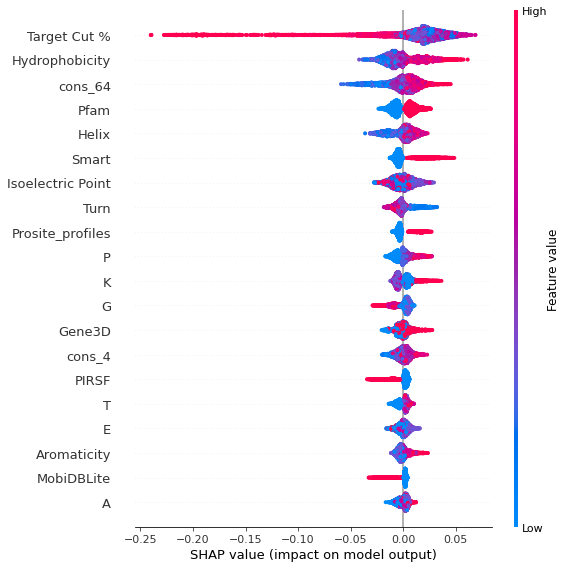

In [14]:
shap.summary_plot(shap_values, X_train_imputed)

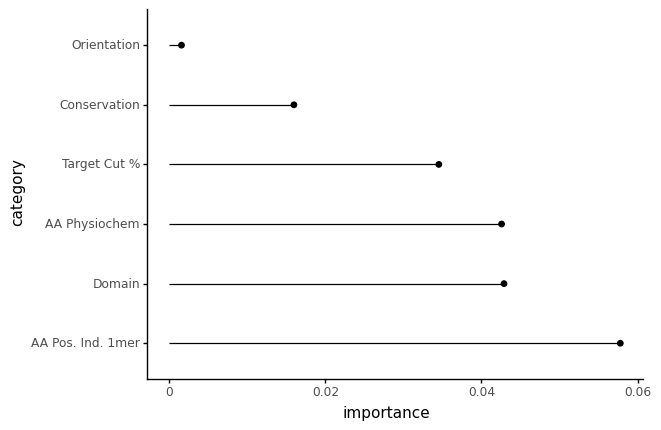

<ggplot: (8761897973767)>

In [23]:
feature_category_map = {'Target Cut %': 'Target Cut %',
                         'Orientation': 'sense',
                         'Domain': ['Pfam', 'PANTHER', 'HAMAP', 'SuperFamily', 'TIGRfam', 'ncoils', 'Gene3D',
                                    'Prosite_patterns', 'Seg', 'SignalP', 'TMHMM', 'MobiDBLite',
                                    'PIRSF', 'PRINTS', 'Smart', 'Prosite_profiles'],
                         'AA Physiochem': ['Hydrophobicity', 'Aromaticity',
                                           'Isoelectric Point', 'Helix', 'Turn', 'Sheet'],
                         'AA Pos. Ind. 1mer': '[A-Z]|\*',
                         'AA Pos. Ind. 2mer': '([A-Z]|\*){2}',
                         'AA Pos. Dep. 1mer': '\-?[0-9]([A-Z]|\*)',
                         'Conservation': ['cons_64', 'cons_4']}

shap_df = pd.DataFrame(shap_values, columns=X_train_imputed.columns)

feature_category_list = []
for category, feature in feature_category_map.items():
    if type(feature) == str:
        matched_cols = shap_df.columns.str.fullmatch(feature)
    else: # list
        matched_cols = shap_df.columns.isin(feature)
    category_features = shap_df.columns[matched_cols]
    feature_category_list.extend([{'feature': f, 'category': category} for f in category_features])
feature_category_df = pd.DataFrame(feature_category_list)
shap_abs_importance = (shap_df.abs().mean(0)
                       .reset_index()
                       .rename({0: 'importance',
                                'index': 'feature'}, axis=1)
                       .sort_values('importance', ascending=False)
                       .merge(feature_category_df, how='inner', on='feature'))
category_importance = (shap_abs_importance.groupby('category')
                       .agg({'importance': 'sum'})
                       .reset_index()
                       .sort_values('importance', ascending=False))
category_importance['category'] = pd.Categorical(category_importance['category'],
                                                 categories=category_importance['category'])

lolliplop_plot(category_importance, 'category', 'importance')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


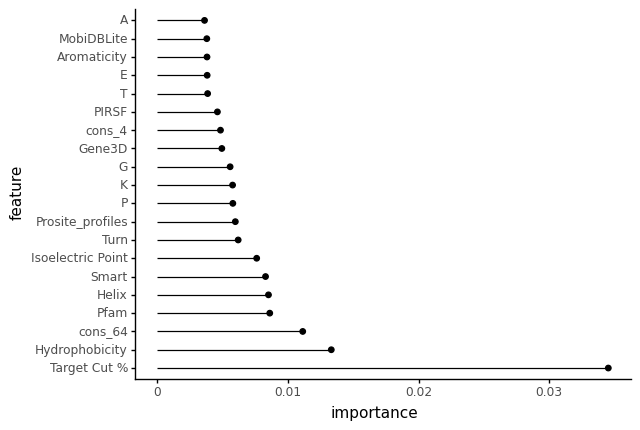

<ggplot: (8761906246876)>

In [24]:
top_n = 20
top_features = shap_abs_importance.head(top_n)
top_features['feature'] = pd.Categorical(top_features['feature'], categories=top_features['feature'])
lolliplop_plot(top_features, 'feature', 'importance')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


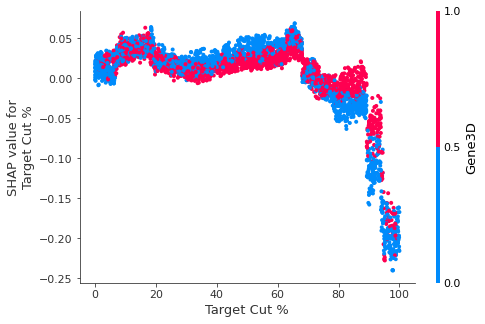

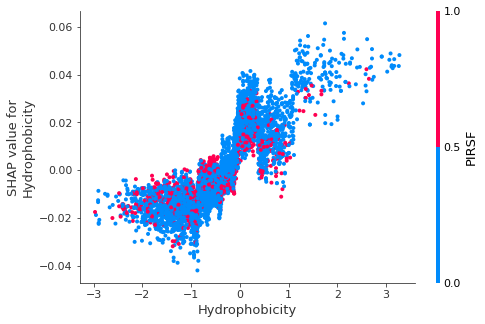

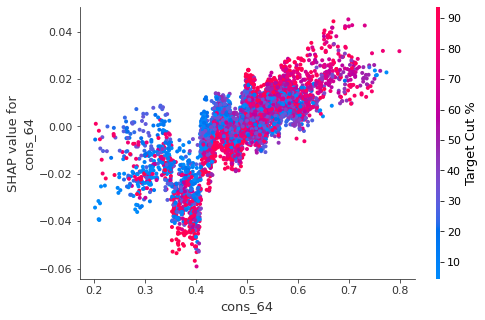

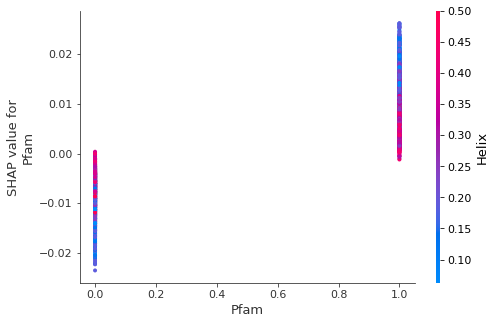

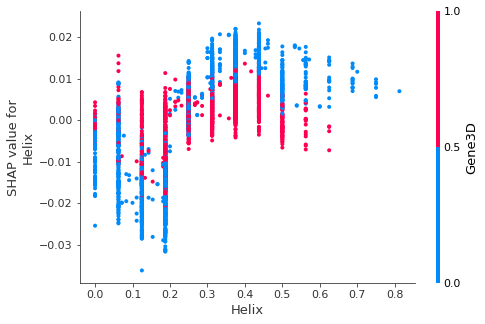

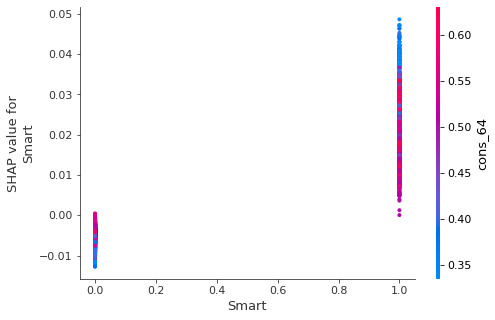

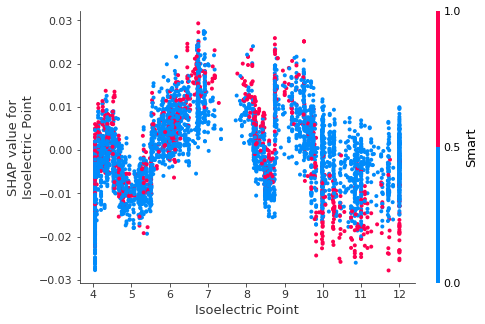

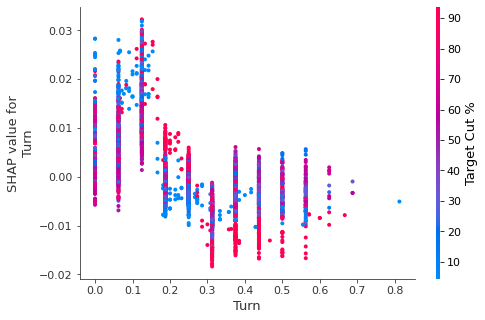

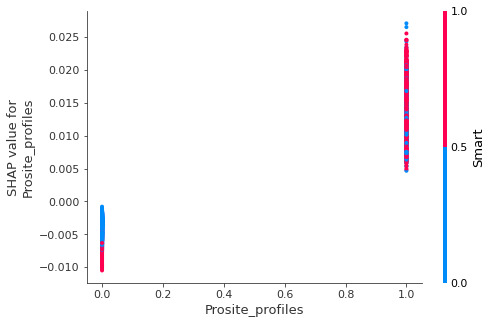

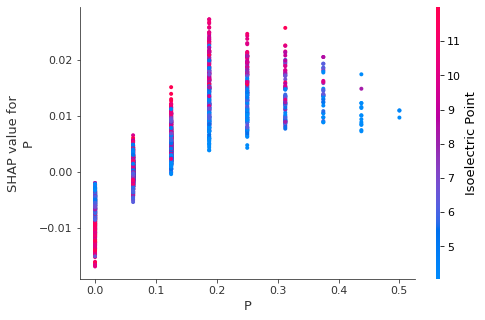

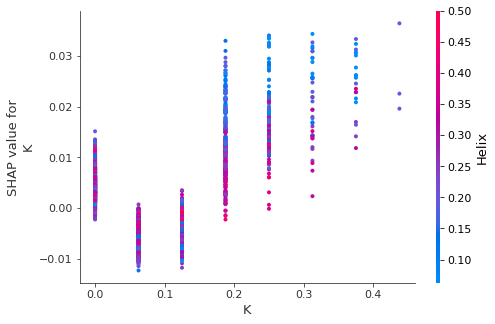

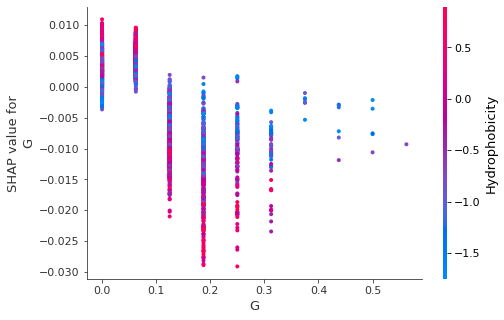

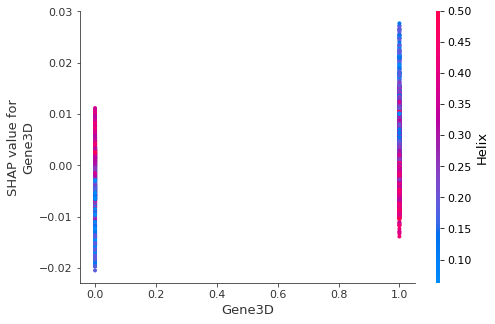

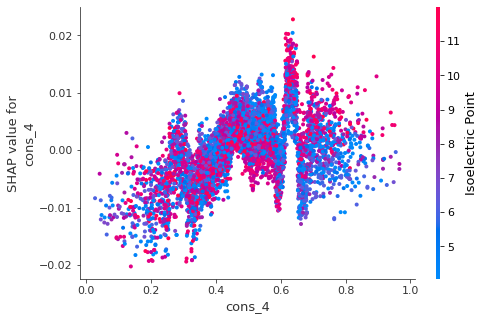

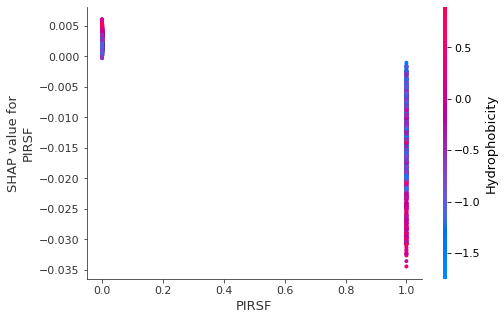

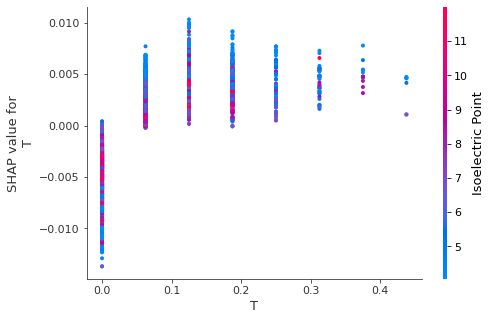

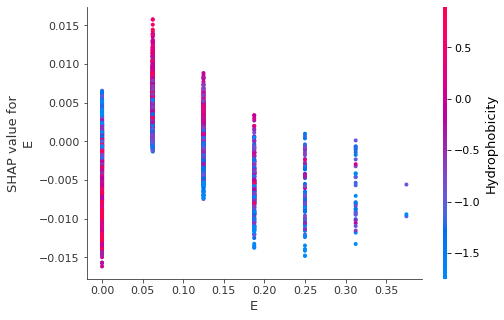

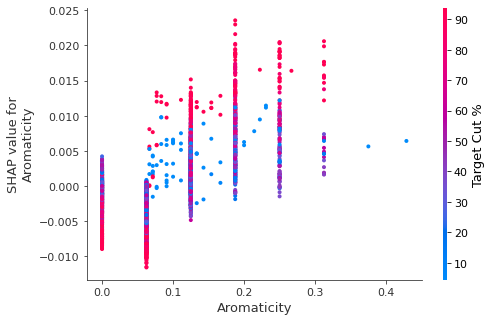

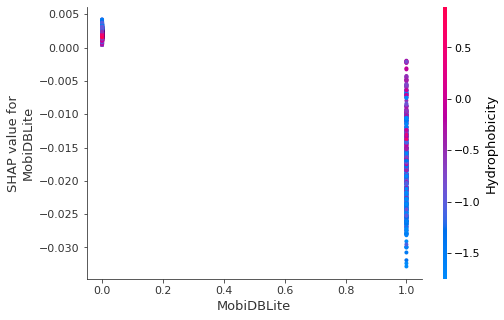

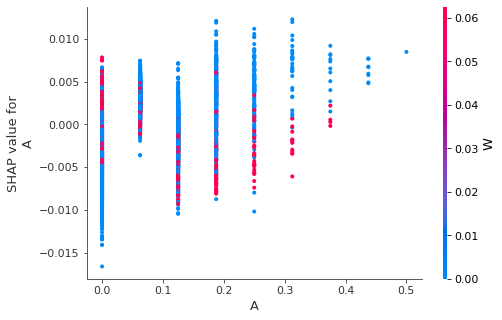

In [26]:
for feature in shap_abs_importance.head(20)['feature']:
    shap.dependence_plot(feature, shap_values, X_train_imputed)


## Amino Acid Feature Importance

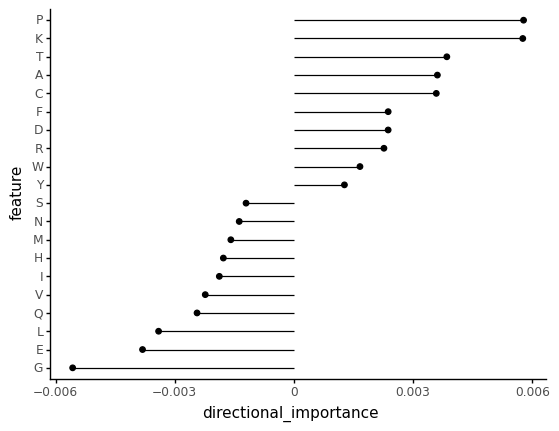

<ggplot: (8761897389846)>

In [18]:
def get_shap_correlation(df):
    if (df['importance'].std() > 0) and (df['value'].std() > 0):
        return stats.pearsonr(df['importance'], df['value'])[0]
    else:
        return pd.NA


long_shap_df = (shap_df.reset_index()
                .rename({'index': 'train_index'}, axis=1)
                .melt(id_vars='train_index', var_name='feature',
                      value_name='importance'))
long_train_df = (X_train_imputed.reset_index(drop=True)
                 .reset_index()
                 .rename({'index': 'train_index'}, axis=1)
                 .melt(id_vars='train_index', var_name='feature',
                       value_name='value'))
long_shap_train_values = (long_shap_df.merge(long_train_df, how='inner',
                                             on=['train_index', 'feature']))
nonzero_shap_train_values = long_shap_train_values[long_shap_train_values['importance'] != 0]
shap_correlations = (nonzero_shap_train_values.groupby('feature')
                     .apply(lambda df: get_shap_correlation(df))
                     .reset_index(name='pearson_r'))
shap_correlations['direction'] = np.sign(shap_correlations['pearson_r'])
shap_directional_importance = (shap_abs_importance.merge(shap_correlations, how='inner',
                                                         on='feature'))
shap_directional_importance['directional_importance'] = (shap_directional_importance['direction'] *
                                                         shap_directional_importance['importance'])
shap_directional_importance = shap_directional_importance.sort_values('directional_importance')
aa_directional_importance = (shap_directional_importance[shap_directional_importance.category == 'AA Pos. Ind. 1mer']
                             .copy())
aa_directional_importance['feature'] = pd.Categorical(aa_directional_importance['feature'],
                                                      categories=aa_directional_importance['feature'])
lolliplop_plot(aa_directional_importance, 'feature', 'directional_importance')

In [19]:
aa_nt_frac = (codon_map_df.groupby('Amino Acid')
              .agg(joined_codons = ('Codon', ''.join))
              .reset_index())


In [20]:
for nt in ['A', 'C', 'T', 'G']:
    aa_nt_frac[nt + ' frac.'] = aa_nt_frac['joined_codons'].str.count(nt)/aa_nt_frac['joined_codons'].str.len()

In [22]:
def make_physiochem_df(physio_dict, name):
    df = (pd.DataFrame.from_dict(physio_dict, orient='index')
          .reset_index()
          .rename({'index': 'Amino Acid',
                   0: name}, axis=1))
    return df


hydrophobicity_df = make_physiochem_df(ProtParamData.kd, 'hydrophobicity')
hydrophilicity_df = make_physiochem_df(ProtParamData.hw, 'hydrophilicity')
sa_df = make_physiochem_df(ProtParamData.em, 'surface accessibility')
ste_df = make_physiochem_df(ProtParamData.ja, 'surface transfer energy')
flex_df = make_physiochem_df(ProtParamData.Flex, 'flexibility')
all_physiochem_df = aa_nt_frac
for df in [hydrophobicity_df, hydrophilicity_df, sa_df, ste_df, flex_df]:
    all_physiochem_df = all_physiochem_df.merge(df, how='inner', on='Amino Acid')
all_physiochem_df = all_physiochem_df.merge(aa_directional_importance[['feature',
                                                                       'directional_importance']], how='left',
                                            left_on='Amino Acid', right_on='feature')
importance_cor = all_physiochem_df.corr().loc[:,'directional_importance']
importance_cor.sort_values()

surface transfer energy   -0.247904
G frac.                   -0.205445
hydrophobicity            -0.153123
T frac.                   -0.045749
A frac.                   -0.022261
flexibility                0.047768
hydrophilicity             0.120966
surface accessibility      0.217401
C frac.                    0.321729
directional_importance     1.000000
Name: directional_importance, dtype: float64

We see the correlation with surface transfer energy has increased, while the correlation with
G content has decreased.